In [25]:
import pandas as pd
import networkx as nx

from rdflib import Graph, URIRef, Literal, Namespace
from pathlib import Path
from operator import itemgetter
from matplotlib import pyplot as plt
from rdflib.namespace import XSD, RDF, RDFS, SKOS

from rdflib.extras.external_graph_libs import *

Visualizing the graph may improve our understanding of the data in the graph. The IReC GitHub repository contains some instructions for visualizing the graph with GraphDB. The `unfeatured_graph.ttl` file probably contains the most appropriate level of information for visualizing our graph. 

In this notebook, we would like to analyse the graph to identify potential concepts. The idea being that they could be added to a manually curated AEC conceptualization. For analysis, we'll use the `featured_graph.ttl` file.

We'll look at some basic graph analysis approaches:
* **Paths** we could be interested in, e.g.;
  * X constitutes Y constitutes Z etc
  
* Finding **central nodes** based, e.g.;
  * which nodes are likely common high-level classes, e.g., materials, systems, etc. (would we want to reweigh phrasese that contain such words?)
  * features that we could consider include the degree (number of edges for a node), betweennes (number of shortest paths that pass through the node), and 'page rank' (importance of node based on importance of related nodes)
      * concept-concept shortest paths may identify related terms, e.g., determine spans that connect the concepts `fire doorset` and `protected corridor`
      * betweennes centrality may suggest high level concepts, e.g., `materials`, `systems` and so on
      * page rank; which spans are connected to the most influential spans (ones with high betweennes or connected direclty to concepts)
* **Community detection**; find groups of closely connected nodes, e.g., we'd like to find all nodes that are directly related to spans revolving around materials. Approaches to use include Label propagation and Unfolding (Louvain) to compute a bottom-up grouping of connected nodes.

To do:
* continue exploring SPARQL + networkX combinations
* check out how to create useful aggregate queries in SPARQL
* For now, we'll avoid looking at pattern matching through worst case optimal join (WCOJ) algorithms.

Add to requirements.txt:
* scipy==1.8
* networkx==3.0

In [2]:
graph_output_fp = Path.cwd().joinpath("data", "graph_output")

In [3]:
IREC_spans_URL = "https://spans.irec.org/"
IREC_concepts_URL = "https://concepts.irec.org/"

### Load Graph

In [4]:
irec_graph = Graph()
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
irec_graph.parse(graph_data_fp.joinpath("IREC.rdf"))
# irec_graph.parse(graph_output_fp.joinpath("unfeatured_graph.ttl"))
# UG = rdflib_to_networkx_graph(irec_graph)

<Graph identifier=N01aff7a3d5644a698e897efbb498ef8d (<class 'rdflib.graph.Graph'>)>

In [5]:
# convert to NetworkX graph
irec_graph.parse(graph_output_fp.joinpath("featured_graph.ttl"))
FG = rdflib_to_networkx_graph(irec_graph)
# G = rdflib_to_networkx_digraph(irec_graph)

### Combine SPARQL and graph computations
* We'll start by isolating the constitutes relations and see what we can do with those

In [36]:
# Single term
user_query = 'impact'
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>

SELECT ?other_label
WHERE {
    ?a irec:constitutes|^irec:constitutes ?b . 
    ?b rdfs:label ?other_label .
    ?a rdfs:label ?value .
    FILTER (CONTAINS(LCASE(str(?value)), "QUERY"))
}
""".replace('QUERY', user_query)

In [7]:
res = irec_graph.query(test_query)

In [8]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
edge_list = []
for row in res:
    if Literal(user_query) != row.other_label:
        edge_list.append([Literal(user_query), row.other_label])

In [16]:
print(f"Number of edges related to `{user_query}`: {len(edge_list)}")

Number of edges related to `impact`: 98


In [10]:
impact_graph = nx.Graph()
impact_graph.add_edges_from(edge_list)

In [17]:
span_degree_dict = dict(FG.degree((g for g in impact_graph.nodes())))
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

Top 20 spans by degree:
1: sound pressure level [3]
2: sound [2]
3: impact sound [2]
4: impact sound insulation [2]
5: fuel [1]
6: pressure [1]
7: impact sound transmission [1]
8: sound transmission [1]
9: transmission [1]
10: insulation [1]
11: Approved [1]
12: Approved Document [1]
13: Conservation [1]
14: direct impact [1]
15: impact [1]
16: impact Approved Document L1A Conservation of fuel [1]
17: impact sound pressure level [1]
18: impact sounds [1]
19: direct [1]
20: direct impacts [1]


In [23]:
mst = nx.minimum_spanning_tree(impact_graph)

EdgeView([(rdflib.term.Literal('impact'), rdflib.term.Literal('fuel', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('pressure', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('level', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('impact sound transmission', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('sound transmission', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('transmission', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('insulation', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('Approved', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('Approved Document', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('Conservation', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('sound', lang='en')), (rdflib.term.Literal('impact'), rdflib.term.Literal('direct impact', lang='en')), (rdflib.term.Literal('imp

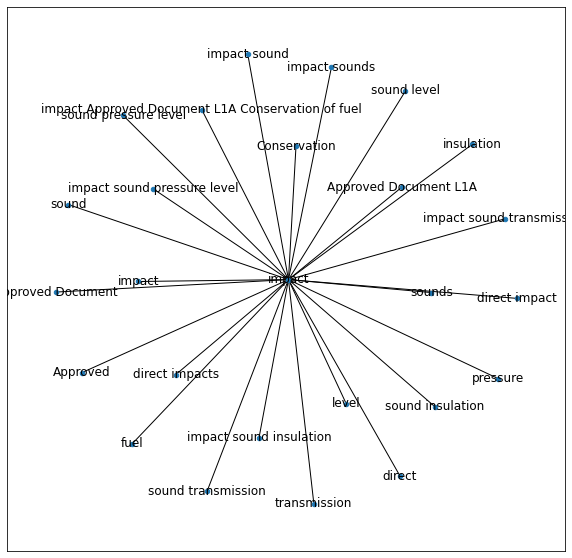

In [35]:

plt.figure(figsize=(10, 10))
nx.draw_networkx(mst, with_labels=True, node_size = 20)
plt.show()

In [37]:
# All constitutes relations
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>

SELECT DISTINCT ?aname ?bname
WHERE {
    ?a irec:constitutes ?b .
    ?a rdfs:label ?aname .
    ?b rdfs:label ?bname . 
}
"""
res = irec_graph.query(test_query)

In [38]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
edge_list = []
for row in res:
    if row.aname != row.bname:
        edge_list.append([row.aname, row.bname])

In [39]:
edge_list[:10]

[[rdflib.term.Literal('www iats - uk org / iats - member - list /', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('structural member in architecture', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('member states', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('member state', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('horizontal member', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('sides member', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('horizontal structural member', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('vertical structural member', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('structural member', lang='en'),
  rdflib.term.Literal('member', lang='en')],
 [rdflib.term.Literal('a horizontal member', lang='en

In [40]:
constitutes_graph = nx.Graph()
constitutes_graph.add_edges_from(edge_list)

In [116]:
# We're grouping terms together that form a network of overlapping words, e.g., (thermal resistance, resistance, fire resistance, fire, etc...)
louvain = nx.algorithms.community.louvain.louvain_communities(constitutes_graph)

In [147]:
# For each group we're going to determine a minimum spanning tree, to identify prominent nodes (rather than degree)
span_degree_dict = {}
mst_list_dict = {}
for idx, community in enumerate(louvain):
    span_degree_dict[idx] = dict(constitutes_graph.degree((g for g in community)))
#     spans_sorted_by_num_edges = sorted(span_degree_dict[idx].items(), key=itemgetter(1), reverse=True)
#     for idx, span_node in enumerate(spans_sorted_by_num_edges[:20]):
#         [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]
    temp_graph = nx.Graph()
    for edge_list in [list(constitutes_graph.edges(node)) for node in community]:
        temp_graph.add_edges_from(edge_list)
    mst = nx.minimum_spanning_tree(temp_graph)
    mst_list_dict[idx] = sorted(mst.edges(data=True))


In [150]:
print([k for k in span_degree_dict.keys() if len(span_degree_dict[k]) > 100])

[6, 9, 18, 19, 21, 54, 62, 72, 78, 82, 83, 91, 101, 102, 106, 116, 121, 137, 138, 151, 167, 170, 176, 188, 227, 239, 253, 254, 263, 264, 340, 343, 350, 363]


In [151]:
mst_list_dict[6]

[(rdflib.term.Literal('A layer that', lang='en'),
  rdflib.term.Literal('A', lang='en'),
  {}),
 (rdflib.term.Literal('A surface layer', lang='en'),
  rdflib.term.Literal('surface', lang='en'),
  {}),
 (rdflib.term.Literal('Every joint fit', lang='en'),
  rdflib.term.Literal('fit', lang='en'),
  {}),
 (rdflib.term.Literal('Pitched roof insulation', lang='en'),
  rdflib.term.Literal('roof', lang='en'),
  {}),
 (rdflib.term.Literal('Pressure', lang='en'),
  rdflib.term.Literal('Pressure differential systems', lang='en'),
  {}),
 (rdflib.term.Literal('Pressure', lang='en'),
  rdflib.term.Literal('Pressure testing 43', lang='en'),
  {}),
 (rdflib.term.Literal('Pressure differential systems', lang='en'),
  rdflib.term.Literal('systems', lang='en'),
  {}),
 (rdflib.term.Literal('Pressure relief valves', lang='en'),
  rdflib.term.Literal('Pressure', lang='en'),
  {}),
 (rdflib.term.Literal('Smoke testing', lang='en'),
  rdflib.term.Literal('Smoke', lang='en'),
  {}),
 (rdflib.term.Literal('So

In [119]:
span_degree_dict = dict(G.degree((g for g in constitutes_graph.nodes())))

In [120]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

Top 20 spans by degree:
1: Hotel [15]
2: Chimneys [11]
3: chemical compound [10]
4: SI unit of power [7]
5: Wall [7]
6: building [6]
7: extension [6]
8: gallery [6]
9: frequency [6]
10: wall [5]
11: landing [5]
12: block [5]
13: polymer [5]
14: permeability [5]
15: enclosure [5]
16: green [4]
17: area [4]
18: common area [4]
19: boundary [4]
20: material [4]


### Identify Paths

In [40]:
UG.edge_subgraph('')

TypeError: edge_subgraph() missing 1 required positional argument: 'edges'

### Connectedness

[{rdflib.term.Literal('Rainwater drainage systems', lang='en'),
  rdflib.term.Literal('metal', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#museum'),
  rdflib.term.URIRef('https://spans.irec.org/#the%20manufacturer'),
  rdflib.term.Literal('gradients', lang='en'),
  rdflib.term.Literal('a subject knowledge', lang='en'),
  rdflib.term.Literal('balcony', lang='en'),
  rdflib.term.Literal('tonal', lang='en'),
  rdflib.term.Literal('simplest organic molecule with one carbon atom and four hydrogen', lang='en'),
  rdflib.term.Literal('disadvantageous', lang='en'),
  rdflib.term.Literal('unable', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#an%20accessible%20bathroom'),
  rdflib.term.Literal('BS EN 1996 - 2', lang='en'),
  rdflib.term.Literal('hinge', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#Tanneries'),
  rdflib.term.URIRef('https://spans.irec.org/#unrestrained'),
  rdflib.term.Literal('resilience', lang='en'),
  rdflib.term.URIRef('https://spans.ir

In [11]:
span_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_spans_URL))))

In [12]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((span_node[0], RDFS.label, None))]

Top 20 spans by degree:
1: house [229]
2: a building [103]
3: building [65]
4: water [61]
5: Hotel [55]
6: pipe [53]
7: Chimneys [50]
8: wall [48]
9: room [45]
10: area [45]
11: extension [44]
12: maintenance [43]
13: ceiling [42]
14: stone [41]
15: people [41]
16: ventilation [41]
17: material [41]
18: the building [40]
19: gallery [38]
20: fire doorset [38]


In [13]:
concept_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_concepts_URL))))

In [14]:
concepts_sorted_by_num_edges = sorted(concept_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 concepts by degree:")
for idx, d in enumerate(concepts_sorted_by_num_edges[:20]):
    # note that the list comprehension here exists for yielding from the generator
    # also the only reason we are skipping the schemeUID is because it doesn't have a prefLabel
    [print(f"{idx}: {c_triple[2]} [{d[1]}]") for c_triple in irec_graph.triples((d[0], SKOS.prefLabel, None))]

Top 20 concepts by degree:
1: fire doorset [36]
2: display window [34]
3: total useful floor area [33]
4: wet room [32]
5: key elements [31]
6: element of structure [31]
7: comité européen de normalisation [30]
8: commissioning [29]
9: unprotected area  [29]
10: specialist process lighting [27]
11: softened wholesome water [26]
12: dwelling [26]
13: unvented hot water storage system [26]
14: room [24]
15: external wall [24]
16: building [23]
17: pipe [23]
18: united kingdom accreditation service [23]
19: surface water activity [23]


### Node centrality

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (Wikipedia)

In [ ]:
clustering = nx.clustering(G)
len(clustering)

In [ ]:
highly_connected_nodes = [n for n, clustering_coefficient in clustering.items() if clustering_coefficient == 0]

In [ ]:
len(highly_connected_nodes)

In [ ]:
print("20 example outlier spans")
for idx, span_node in enumerate(highly_connected_nodes[1:21]):
    [print(f"{idx + 1}: {s_triple[2]}") for s_triple in irec_graph.triples((span_node, RDFS.label, None))]

In [23]:
louvain = nx.algorithms.community.louvain.louvain_communities(G)

In [24]:
len(louvain)

248

In [25]:
for idx, community in enumerate(louvain):
    print(f"Community [{idx}] of size {len(community)}, 20 spans by degree:")
    span_degree_dict = dict(G.degree((g for g in community if str(g).startswith(IREC_spans_URL))))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
        [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((span_node[0], RDFS.label, None))]

Community [0] of size 1775 op 20 spans by degree:
1: heating system [223]
2: ventilation systems [221]
3: ventilation system [220]
4: Heating systems [207]
5: water [205]
6: storage system [201]
7: surface water [200]
8: Protection systems [197]
9: Lighting systems [193]
10: pipe systems [190]
11: gas systems [185]
12: water level [176]
13: ventilation opening [172]
14: Ventilation openings [170]
15: solar system [169]
16: mechanical systems [169]
17: alarm systems [167]
18: ventilation openings [167]
19: water storage [166]
20: space heating [166]
Community [1] of size 2560 op 20 spans by degree:
1: The building [1446]
2: the wall [1417]
3: the walls [1411]
4: the Wall [1407]
5: the area [1383]
6: the floor [1383]
7: the system [1367]
8: The system [1361]
9: the roof [1347]
10: the door [1345]
11: the water [1344]
12: The doors [1343]
13: the doors [1339]
14: The door [1337]
15: the rooms [1335]
16: the roofing [1333]
17: the ventilation [1325]
18: the space [1323]
19: the ventilator 

{rdflib.term.URIRef('https://spans.irec.org/#convection'),
 rdflib.term.URIRef('https://spans.irec.org/#frail'),
 rdflib.term.Literal('Rainwater drainage systems', lang='en'),
 rdflib.term.Literal('metal', lang='en'),
 rdflib.term.URIRef('https://spans.irec.org/#rh-negative'),
 rdflib.term.URIRef('https://spans.irec.org/#trussed%20beam'),
 rdflib.term.URIRef('https://spans.irec.org/#museum'),
 rdflib.term.Literal('incompetent', lang='en'),
 rdflib.term.Literal('gradients', lang='en'),
 rdflib.term.URIRef('https://www.wikidata.org/wiki/#Q113459391'),
 rdflib.term.URIRef('https://spans.irec.org/#flexible%20membrane'),
 rdflib.term.Literal('balcony', lang='en'),
 rdflib.term.URIRef('https://spans.irec.org/#effortless'),
 rdflib.term.Literal('tonal', lang='en'),
 rdflib.term.URIRef('https://spans.irec.org/#Commission%20Decision%202000%20/%20553%20/%20EC'),
 rdflib.term.Literal('a variety of sound, usually meaning any unwanted sound', lang='en'),
 rdflib.term.Literal('Offices', lang='en'),


In [7]:
L = nx.laplacian_matrix(G)

In [8]:
L

<35592x35592 sparse array of type '<class 'numpy.int64'>'
	with 224167 stored elements in Compressed Sparse Row format>